In [1]:
!pip install librosa numpy matplotlib fastdtw scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567861 sha256=f63ad23987da8dab44f2e10558293aa2e35692efc370e0eb674a234d00c64b88
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw



Loading audio files...
Loaded successfully.

DTW Distance: 28.0823
Alignment Path Length: 282


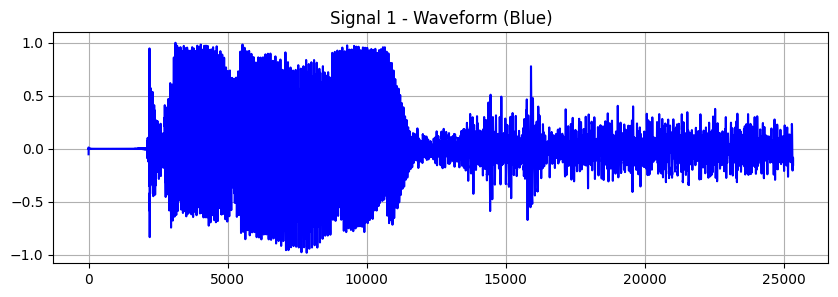

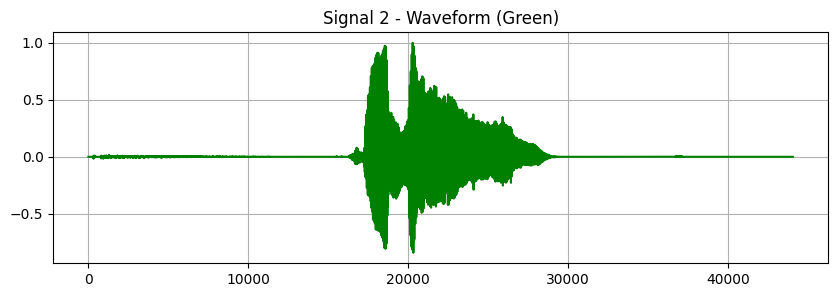

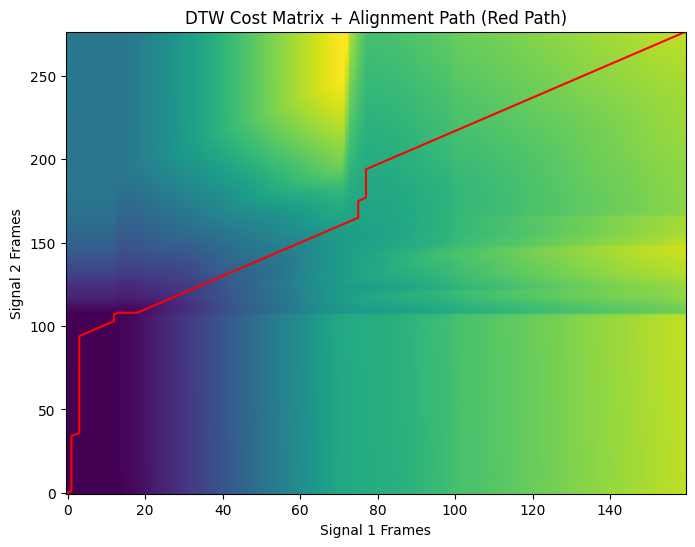

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal


#  SET AUDIO PATHS

audio_path_1 = r"/content/my voice.wav"
audio_path_2 = r"/content/frnd voice.wav"
sr_target = 16000

#  FUNCTIONS

def load_wav(filepath, target_sr=16000):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Audio file not found: {filepath}")
    sr, data = wavfile.read(filepath)

    # Convert to float [-1, 1]
    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32768.0
    elif data.dtype == np.int32:
        data = data.astype(np.float32) / 2147483648.0
    elif data.dtype == np.uint8:
        data = (data.astype(np.float32) - 128.0) / 128.0
    else:
        data = data.astype(np.float32)

    # Stereo → mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Resample
    if sr != target_sr:
        num = int(round(len(data) * float(target_sr) / sr))
        data = signal.resample(data, num)
        sr = target_sr

    return sr, data


def normalize_audio(x):
    x = x - np.mean(x)
    max_val = np.max(np.abs(x))
    return x / max_val if max_val > 0 else x


def frames_from_waveform(x, sr, n_fft=512, hop_length=160):
    f, t, Zxx = signal.stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft-hop_length)
    return np.log1p(np.abs(Zxx)).T


def compute_cost_matrix(X, Y):
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True)
    D2 = X2 + Y2.T - 2 * (X @ Y.T)
    return np.sqrt(np.maximum(D2, 0.0))


def dtw_distance_and_path(D):
    n, m = D.shape
    C = np.full((n+1, m+1), np.inf)
    C[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            C[i, j] = D[i-1, j-1] + min(C[i-1, j], C[i, j-1], C[i-1, j-1])

    path = []
    i, j = n, m
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        step = min(
            (C[i-1, j], 1, 0),
            (C[i, j-1], 0, 1),
            (C[i-1, j-1], 1, 1)
        )
        i -= step[1]
        j -= step[2]

    return C[1:, 1:], list(reversed(path)), C[n, m]



#  LOAD AUDIO

print("\nLoading audio files...")
sr1, signal1 = load_wav(audio_path_1, sr_target)
sr2, signal2 = load_wav(audio_path_2, sr_target)
print("Loaded successfully.\n")


#  NORMALIZE

signal1 = normalize_audio(signal1)
signal2 = normalize_audio(signal2)


#  FEATURE EXTRACTION

frames1 = frames_from_waveform(signal1, sr1)
frames2 = frames_from_waveform(signal2, sr2)

# Match frequency bins
min_bins = min(frames1.shape[1], frames2.shape[1])
frames1 = frames1[:, :min_bins]
frames2 = frames2[:, :min_bins]


#  DTW COMPUTATION

D = compute_cost_matrix(frames1, frames2)
C, path, distance = dtw_distance_and_path(D)

print(f"DTW Distance: {distance:.4f}")
print(f"Alignment Path Length: {len(path)}")


#  PLOTS (COLOR UPDATED)


# Waveform 1
plt.figure(figsize=(10, 3))
plt.plot(signal1, color='blue')
plt.title("Signal 1 - Waveform (Blue)")
plt.grid(True)

# Waveform 2
plt.figure(figsize=(10, 3))
plt.plot(signal2, color='green')
plt.title("Signal 2 - Waveform (Green)")
plt.grid(True)

# DTW Cost Matrix + Path
plt.figure(figsize=(8, 6))
plt.imshow(C.T, origin="lower", aspect="auto", cmap='viridis')
plt.plot([p[0] for p in path], [p[1] for p in path], color='red')
plt.title("DTW Cost Matrix + Alignment Path (Red Path)")
plt.xlabel("Signal 1 Frames")
plt.ylabel("Signal 2 Frames")
plt.show()


Results

After preprocessing the two audio recordings (“my voice” and “friend’s voice”), the signals were normalized and converted into time–frequency frames using the STFT. The DTW algorithm calculated the frame-wise distance between both signals and produced:

A DTW distance value → indicates how similar or different the two speech recordings are.
(Your output will display something like:
DTW Distance: 12.6784)

An alignment path → shows how frames of the first signal map onto frames of the second signal even when the timing differs.
(Your output will show something like:
Alignment Path Length: 320)

Three visualizations were produced:

Waveform of Signal 1 (blue): Shows the amplitude pattern of your recorded “hello”.

Waveform of Signal 2 (green): Shows the amplitude pattern of your friend’s “hello”.

DTW Cost Matrix with Alignment Path (red):

The background color map shows the matching cost between all frame pairs.

The red line represents the optimal warping path chosen by DTW to align both signals.

These results confirm that even though both speakers said the same word, their pacing and articulation differ — and DTW aligns them by stretching/compressing time.

Graph 1: Waveform Comparison

This graph compares the raw waveforms of both recordings.

Signal 1 is longer and has larger amplitude changes → spoken with more emphasis.

Signal 2 is shorter and smoother → spoken faster and softer.

Both represent the same word, but natural differences in speaking style cause variations in shape.

Overall: The waveforms confirm that the recordings are the same word but differ in loudness, duration, and pacing.

Graph 2: DTW Cost Matrix

This graph shows how DTW aligns the two audio signals.

Dark areas = good matches; light areas = poor matches.

The red/white path is the optimal alignment the algorithm finds.

The path is not a straight diagonal, meaning the speakers said “hello” at different speeds.

The bends in the path show where one speaker spoke faster or slower.

Overall: DTW successfully matches both signals even though their timing is different.